# **Homework 4**
### *Topics in Data Science*
#### Josh Winnes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering
from skmob.preprocessing import compression



pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

In [2]:
"""
    sorting the event data frame by user ID and then by time is the most critical step.
"""
os.chdir('/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

tortoise.insert(loc = 2, column = "timestamp_UTC",
                value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
                )
tortoise.insert(loc = 3, column = "timestamp_local", 
                value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
                )
tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)
tortoise.insert(loc = 4, column = "minute_diff", 
                value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
                    .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
                    )
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise["month_since2009"] = (tortoise.year - tortoise.year.min())*12 + tortoise.month
tortoise["day_since_min"] = (tortoise["timestamp_local"] - tortoise.timestamp_local.min()).apply(lambda x: x.days)
tortoise.reset_index(drop=True, inplace=True)

In [3]:
tortoise_gdf = gpd.GeoDataFrame(tortoise)
tortoise_gdf["geometry"] = gpd.points_from_xy(tortoise_gdf.location_long, tortoise_gdf.location_lat)
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)

In [4]:
tortoise_jl = jump_lengths(tortoise_trajectory)
tortoise_jl["jump_lengths"] = \
    tortoise_jl["jump_lengths"].apply(
        lambda x: np.append(x,np.nan).tolist())
tortoise_jl = tortoise_jl.explode(["jump_lengths"],
                ignore_index=True).reset_index(drop=True)
tortoise["jump_length"] = tortoise_jl.jump_lengths
tortoise_trajectory["jump_length"] = tortoise_jl["jump_lengths"]

100%|██████████| 96/96 [00:06<00:00, 15.71it/s]


In [5]:
import osmnx as ox
place_name = "Galapagos, Ecuador" #Isla Santa Cruz, Galapagos, Ecuador
santa_cruz_gdf = ox.geocode_to_gdf(place_name)
tessellation = tilers.tiler.get("h3_tessellation", base_shape=santa_cruz_gdf,meters =200)
tessellation["tile_lng"] = tessellation.geometry.centroid.x
tessellation["tile_lat"] = tessellation.geometry.centroid.y

In [6]:
tortoise_trajectory_mapping = tortoise_trajectory.mapping(tessellation,remove_na =True) # map trajectory into tessellation tiles
tortoise_tiled = tortoise_trajectory_mapping.merge(tessellation, on = "tile_ID", how = "inner") # join to get the tile coordinates
tortoise_tiled.drop(columns =["lat","lng"], inplace=True) # drop the original lat/lng so that we can create new trajectory
tortoise_tiled.sort_values(by = ["uid", "datetime"], inplace=True) # sort before making trajectory
tortoise_tiled_trajectory = skmob.TrajDataFrame(tortoise_tiled, latitude='tile_lat', longitude='tile_lng', \
    user_id='uid', datetime='datetime', \
)
tortoise_trajectory_compressed = compression.compress(tortoise_trajectory, spatial_radius_km=0.02) # compressed trajectory
tortoise_tiled_trajectory_compressed = compression.compress(tortoise_tiled_trajectory, spatial_radius_km=0.02) # compressed trajectory
tortoise_stay_location = detection.stay_locations(tortoise_trajectory, 
    stop_radius_factor=0.02, minutes_for_a_stop=400, spatial_radius_km=0.2, leaving_time=True)

In [7]:
color_list = ['#883399','#66c066', '#ff800c','#60ff78','#301e4b'] # purple, green, orange, lime, dark purple
color_list.extend(list(sns.color_palette('tab10').as_hex()))
color_list = color_list * 3 # extend the list by repeating 3 times

month_date_str = '05-01' # adjust this date for analysis needs
start_year = 2010
end_year = 2019
year_list = range(start_year, end_year)
s_date = []
for i in range(start_year, end_year+1):
    s_date.append(pd.Timestamp(str(i)+'-' +month_date_str).tz_localize(tz = 'US/Pacific'))
e_date = s_date[1:]
s_date.pop()

Timestamp('2019-05-01 00:00:00-0700', tz='US/Pacific')

download the spatial-temporal dataset, read into notebook and prepare the data frame, make sure to include columns of: timestamp, latitude, longitude, tortoise ID, and other information

one simple method to detect migration might be through distance of movement: suppose you select day as the unit of time, if you can compute movement scale for each unit, the days with larger scale of movement are the days of migration

you can use radius of gyration, or total trajectory length, to measure scale of movement

you can implement haversine function, or use existing library functions

you can design your other ways of migration detection and implement them, for instance, you may want to investigate using the speed and heading in the dataset

run your migration detection on following tortoises:
Alison, Marilyn, Kitty, Connor, Helber, Christian, Steve Devine

for each tortoise conclude on which dates did the tortoise start the migration, and on which dates did they end the migration


## Alison

In [8]:
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
alison_gdf = tortoise_gdf[tortoise_gdf["individual_local_identifier"] == "Alison"]
alison_trajectory = tortoise_trajectory.query("uid == 'Alison'")
alison_trajectory_mapping = tortoise_trajectory_mapping.query("uid == 'Alison'")
alison_tiled_trajectory = tortoise_tiled_trajectory.query("uid == 'Alison'")
alison_trajectory_compressed = tortoise_trajectory_compressed.query("uid == 'Alison'")
alison_tiled_trajectory_compressed = tortoise_tiled_trajectory_compressed.query("uid == 'Alison'")
alison_stay_location = tortoise_stay_location.query("uid == 'Alison'")

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

In [10]:
from skmob.measures.individual import radius_of_gyration

date = pd.to_datetime('2010-09-17').date()

radius_of_gyration(alison_trajectory[alison_trajectory["date"] == date])["radius_of_gyration"]

100%|██████████| 1/1 [00:00<00:00, 348.80it/s]


0    0.019516
Name: radius_of_gyration, dtype: float64

In [11]:

# Assuming you already have a TrajDataFrame with a 'date' column
# tdf is your TrajDataFrame

# Create a function to calculate radius of gyration for each group
def calculate_radius_of_gyration(group):
    # Apply the radius_of_gyration function to the group (sub-trajectory for the day)
    return radius_of_gyration(group)

# Group the TrajDataFrame by the 'date' column and calculate the radius of gyration for each group
daily_radius_of_gyration = alison_trajectory.groupby(['year', 'month']).apply(calculate_radius_of_gyration)

# Convert the result to a DataFrame for better viewing
daily_radius_of_gyration = pd.DataFrame(daily_radius_of_gyration, columns=['radius_of_gyration'])

# Display the result
print(daily_radius_of_gyration)

100%|██████████| 1/1 [00:00<00:00, 415.77it/s]


              radius_of_gyration
year month                      
2010 9     0            0.046448
     10    0            0.064495
     11    0            0.048214
     12    0            0.049740
2011 1     0            0.084617
     2     0            0.068953
     3     0            0.051429
     4     0            0.059670
     5     0            0.052375
     6     0            0.074980
     7     0            0.049321
     8     0            0.035649
     9     0            0.075657
     10    0            0.081511
     11    0            0.038519
     12    0            0.129576
2012 1     0            0.045693
     2     0            0.121626
     3     0            0.125150
     4     0            0.053781
     5     0            0.075372
     6     0            0.078578
     7     0            0.074229
     8     0            0.071167
     9     0            0.111542
     10    0            0.406381
     11    0            0.258377
     12    0            0.937346
2013 1    

In [12]:
daily_radius_of_gyration.head()

radius_of_gyration
year month                      
2010 9     0            0.046448
     10    0            0.064495
     11    0            0.048214
     12    0            0.049740
2011 1     0            0.084617

In [13]:
alison_trajectory = alison_trajectory.merge(daily_radius_of_gyration, how='left', on=['year', 'month'])

In [14]:
alison_trajectory

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_taxon_canonical_name,uid,year,month,date,month_since2009,day_since_min,jump_length,radius_of_gyration
0,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.043753,0.046448
1,46119278,2010-09-17 18:00:58.001,2010-09-17 18:00:58.001000+00:00,2010-09-17 11:00:58.001000-07:00,59,-90.242230,-0.635563,19,0.21,19.01,143.6,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.005815,0.046448
2,46119279,2010-09-17 19:00:56.001,2010-09-17 19:00:56.001000+00:00,2010-09-17 12:00:56.001000-07:00,59,-90.242210,-0.635515,22,0.15,359.14,171.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.017794,0.046448
3,46119280,2010-09-17 20:00:29.000,2010-09-17 20:00:29+00:00,2010-09-17 13:00:29-07:00,59,-90.242227,-0.635356,19,0.75,19.66,156.2,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.016623,0.046448
4,46119281,2010-09-17 21:00:56.000,2010-09-17 21:00:56+00:00,2010-09-17 14:00:56-07:00,60,-90.242101,-0.635276,17,0.08,342.75,160.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.003791,0.046448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39998,7513055042,2018-10-01 12:00:24.999,2018-10-01 12:00:24.999000+00:00,2018-10-01 05:00:24.999000-07:00,59,-90.243718,-0.635341,8,0.20,12.45,162.8,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.003474,0.004556
39999,7513055043,2018-10-01 13:00:30.001,2018-10-01 13:00:30.001000+00:00,2018-10-01 06:00:30.001000-07:00,60,-90.243748,-0.635348,7,0.17,16.38,166.0,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.002506,0.004556
40000,7513055044,2018-10-01 14:00:55.999,2018-10-01 14:00:55.999000+00:00,2018-10-01 07:00:55.999000-07:00,60,-90.243731,-0.635363,9,0.25,16.38,168.2,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.008986,0.004556
40001,7513055045,2018-10-01 15:00:28.001,2018-10-01 15:00:28.001000+00:00,2018-10-01 08:00:28.001000-07:00,59,-90.243696,-0.635290,10,2.16,217.58,184.6,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.002163,0.004556


<Axes: xlabel='date', ylabel='radius_of_gyration'>

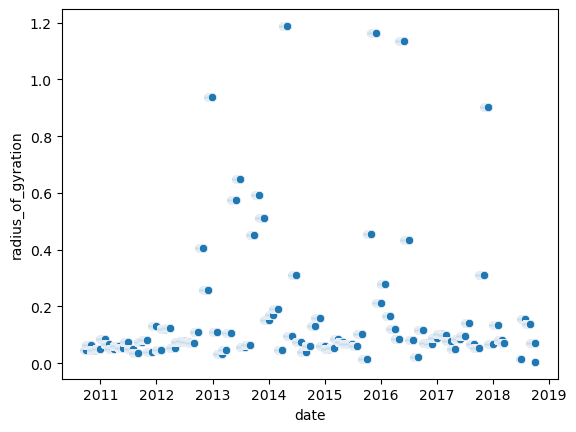

In [15]:
sns.scatterplot(alison_trajectory, x='date', y='radius_of_gyration')

<Axes: xlabel='month', ylabel='radius_of_gyration'>

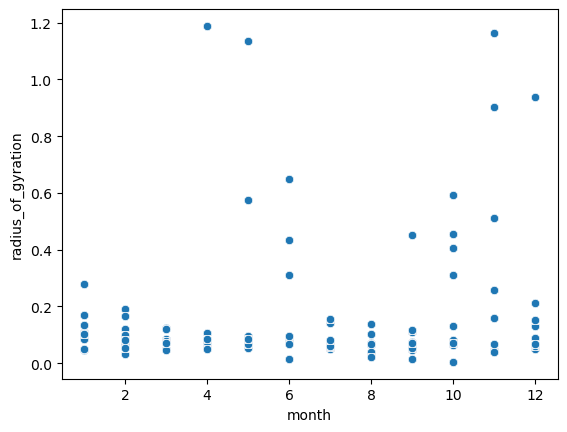

In [19]:
sns.scatterplot(alison_trajectory, x='month', y='radius_of_gyration')

In [21]:
alison_trajectory

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_taxon_canonical_name,uid,year,month,date,month_since2009,day_since_min,jump_length,radius_of_gyration
0,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.043753,0.046448
1,46119278,2010-09-17 18:00:58.001,2010-09-17 18:00:58.001000+00:00,2010-09-17 11:00:58.001000-07:00,59,-90.242230,-0.635563,19,0.21,19.01,143.6,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.005815,0.046448
2,46119279,2010-09-17 19:00:56.001,2010-09-17 19:00:56.001000+00:00,2010-09-17 12:00:56.001000-07:00,59,-90.242210,-0.635515,22,0.15,359.14,171.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.017794,0.046448
3,46119280,2010-09-17 20:00:29.000,2010-09-17 20:00:29+00:00,2010-09-17 13:00:29-07:00,59,-90.242227,-0.635356,19,0.75,19.66,156.2,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.016623,0.046448
4,46119281,2010-09-17 21:00:56.000,2010-09-17 21:00:56+00:00,2010-09-17 14:00:56-07:00,60,-90.242101,-0.635276,17,0.08,342.75,160.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17,21,506,0.003791,0.046448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39998,7513055042,2018-10-01 12:00:24.999,2018-10-01 12:00:24.999000+00:00,2018-10-01 05:00:24.999000-07:00,59,-90.243718,-0.635341,8,0.20,12.45,162.8,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.003474,0.004556
39999,7513055043,2018-10-01 13:00:30.001,2018-10-01 13:00:30.001000+00:00,2018-10-01 06:00:30.001000-07:00,60,-90.243748,-0.635348,7,0.17,16.38,166.0,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.002506,0.004556
40000,7513055044,2018-10-01 14:00:55.999,2018-10-01 14:00:55.999000+00:00,2018-10-01 07:00:55.999000-07:00,60,-90.243731,-0.635363,9,0.25,16.38,168.2,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.008986,0.004556
40001,7513055045,2018-10-01 15:00:28.001,2018-10-01 15:00:28.001000+00:00,2018-10-01 08:00:28.001000-07:00,59,-90.243696,-0.635290,10,2.16,217.58,184.6,Chelonoidis donfaustoi,Alison,2018,10,2018-10-01,118,3441,0.002163,0.004556


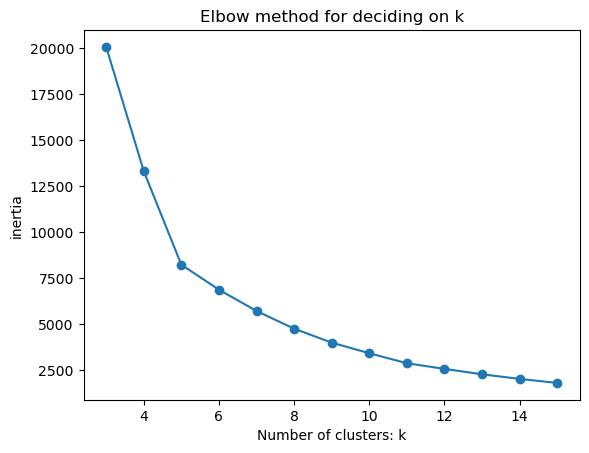

In [75]:
df = alison_trajectory
colnames = ["day_since_min", 'radius_of_gyration']
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

In [76]:
k = 5
alison_kmeans = run_kmeans(alison_trajectory, colnames,k,)
alison_kmeans.groupby("cluster").size()

cluster
0    12535
1    10832
2     3862
3     2132
4    10642
dtype: int64

<Axes: xlabel='day_since_min', ylabel='radius_of_gyration'>

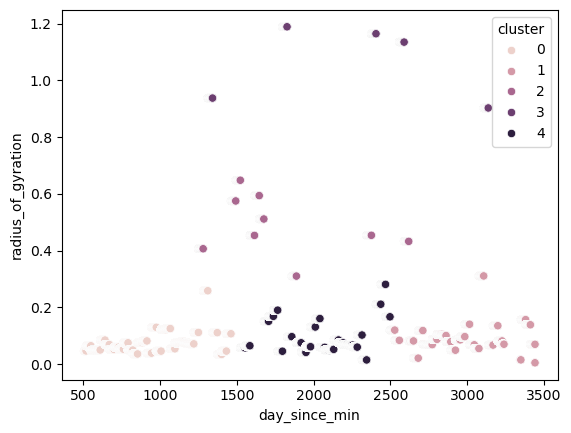

In [77]:
sns.scatterplot(alison_kmeans, x='day_since_min', y="radius_of_gyration", hue="cluster")

<Axes: xlabel='lat', ylabel='lng'>

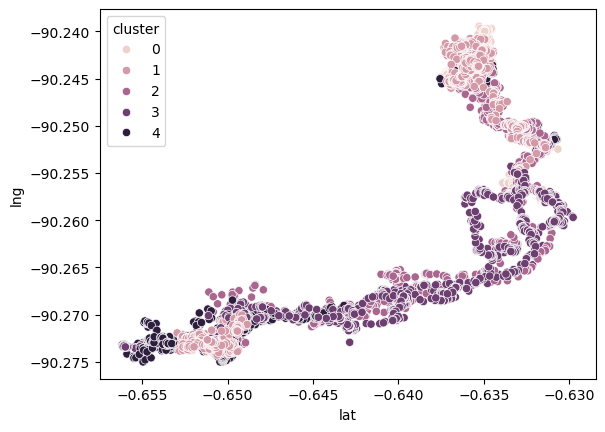

In [78]:
sns.scatterplot(alison_kmeans, x="lat", y="lng", hue="cluster")

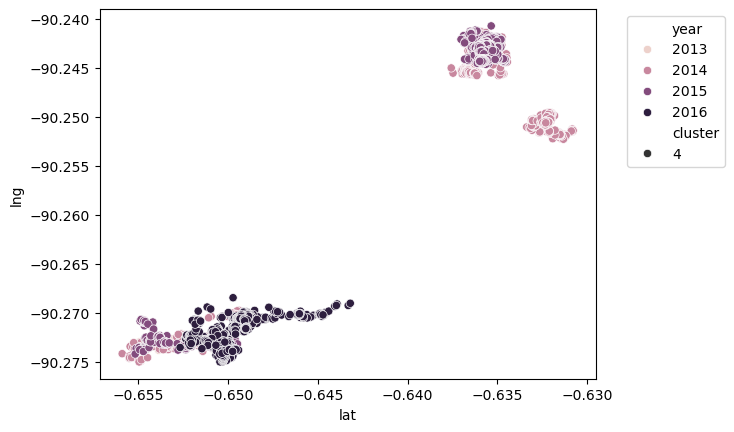

In [85]:
sns.scatterplot(alison_kmeans.query('cluster == 4'), x="lat", y="lng",hue= "year", style ="cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [86]:
alison_departure_dates = pd.DataFrame(alison_kmeans.groupby(['cluster'])['date'].min())

In [87]:
alison_departure_dates

,date
cluster,
0,2010-09-17
1,2016-03-12
2,2012-10-01
3,2012-12-01
4,2013-07-01


In [88]:
alison_arrival_dates = pd.DataFrame(alison_kmeans.groupby(['cluster'])['date'].max())

In [89]:
alison_arrival_dates

,date
cluster,
0,2013-04-30
1,2018-10-01
2,2016-06-30
3,2017-11-30
4,2016-03-12


<Axes: xlabel='lng', ylabel='lat'>

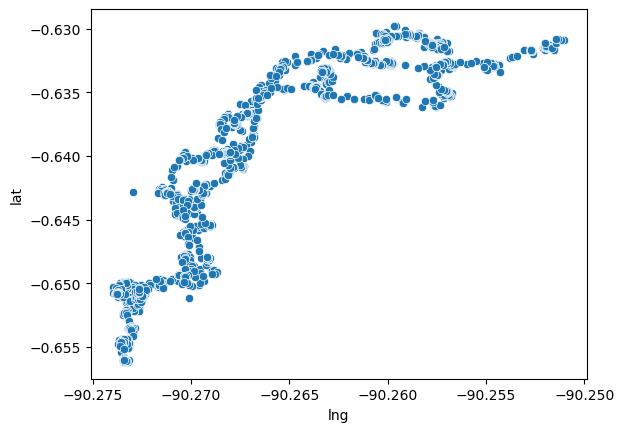

In [99]:
sns.scatterplot(alison_kmeans.query('cluster == 3'), x='lng', y='lat')